<a href="https://colab.research.google.com/github/khalit7/PyTorchMnistClassification/blob/main/PyTorchMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install hiddenlayer

In [5]:
!pip install torchsummary

In [6]:
import torch
import torchvision
import torch
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import hiddenlayer as hl
from torchsummary import summary
from IPython.display import Image

import matplotlib.pyplot as plt

import sys


In [7]:

batch_size = 32
n_epochs = 50

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [8]:
train_set = torchvision.datasets.FashionMNIST (root = ".", train = True ,
download = True , transform = transforms.ToTensor ())
test_set = torchvision .datasets. FashionMNIST (root = ".", train = False ,
download = True , transform = transforms.ToTensor ())
training_loader = torch.utils.data.DataLoader (train_set , batch_size = batch_size,
shuffle = False)
test_loader = torch.utils.data.DataLoader (test_set , batch_size = batch_size,
shuffle = False)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Displaying an example of the data


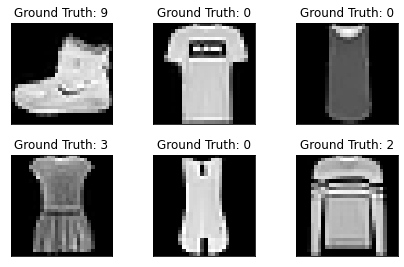

In [9]:
example = enumerate(training_loader)
batc_idx , (example_data,example_target) = next(example)
example_data.shape
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_target[i]))
  plt.xticks([])
  plt.yticks([])

define the training and testing functions

In [17]:
def train(epoch,model,show_progress=True):
  model.train()
  train_loss=0
  correct = 0
  for batch_idx, (data, target) in enumerate(training_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum()
  train_loss /= len(training_loader)
  acc = 100. * correct / len(training_loader.dataset)
  train_losses.append(train_loss)
  train_acc.append(acc)
  if show_progress:
    print(" \t Training Loss: {:.6f} , Accuracy: {}/{} ({:.0f}%)\n".format(train_loss, correct, len(training_loader.dataset),
      acc))
  return acc

In [12]:
def test(model,show_progress=True):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  acc = 100. * correct / len(test_loader.dataset)
  test_acc.append(acc)
  if show_progress:
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      acc))

  return acc

#Question2 Task B. as requested in the question, I used the following configurations:

1.   archectecture described in the assignment pdf
2.   xaviar initialization
3.   learning rate of 0.1
4.   SGD optimizer.
5.   50 epochs




## creating the network and initialize parameters

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024,1024)
        self.fc2 = nn.Linear(1024,256)
        self.fc3 = nn.Linear(256,10)

        self.initializer_wights()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 1024)
        x = F.relu (self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)
    
    def initializer_wights(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m,nn.Linear):
          nn.init.xavier_normal_(m.weight)

## setting the learning rate and the optimizer

In [ ]:
learning_rate = 0.1
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

## displaying the model's archetecture

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
            Conv2d-2             [-1, 64, 8, 8]          51,264
            Linear-3                 [-1, 1024]       1,049,600
            Linear-4                  [-1, 256]         262,400
            Linear-5                   [-1, 10]           2,570
Total params: 1,366,666
Trainable params: 1,366,666
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 5.21
Estimated Total Size (MB): 5.40
----------------------------------------------------------------


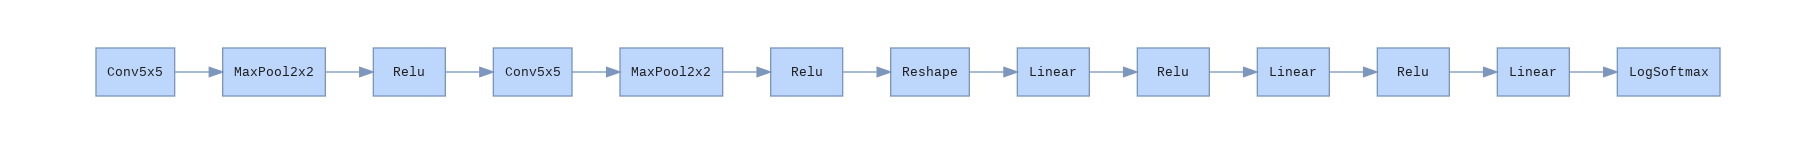

In [ ]:
summary(network,(1,28,28))
transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.

graph = hl.build_graph(network, example_data,transforms = transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('CNN_Model', format='png')
Image('CNN_Model.png')

##Training the model

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
print("Training ... ")
for epoch in range(1, n_epochs + 1):
  print("epoch {}/{}----------------------------------------------------------------------".format(epoch,n_epochs))
  train(epoch,network)
  test(network)

Training ... 
epoch 1/50----------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


 	 Training Loss: 0.517843 , Accuracy: 48405/60000 (81%)



/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3702, Accuracy: 8631/10000 (86%)

epoch 2/50----------------------------------------------------------------------
 	 Training Loss: 0.320231 , Accuracy: 52855/60000 (88%)


Test set: Avg. loss: 0.3175, Accuracy: 8846/10000 (88%)

epoch 3/50----------------------------------------------------------------------
 	 Training Loss: 0.271297 , Accuracy: 53916/60000 (90%)


Test set: Avg. loss: 0.3049, Accuracy: 8904/10000 (89%)

epoch 4/50----------------------------------------------------------------------
 	 Training Loss: 0.237278 , Accuracy: 54682/60000 (91%)


Test set: Avg. loss: 0.2981, Accuracy: 8960/10000 (90%)

epoch 5/50----------------------------------------------------------------------
 	 Training Loss: 0.209276 , Accuracy: 55338/60000 (92%)


Test set: Avg. loss: 0.2930, Accuracy: 8958/10000 (90%)

epoch 6/50----------------------------------------------------------------------
 	 Training Loss: 0.182957 , Accuracy: 55956/60000 (93%)


Test set: Avg.

##plotting training and test accuracies per epoch

Text(0, 0.5, 'percentage of correct classifications')

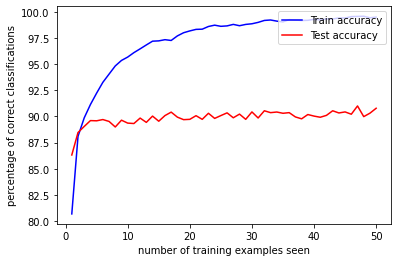

In [ ]:
fig = plt.figure()
plt.plot(range(1,n_epochs+1), train_acc, color='blue')
plt.plot(range(1,n_epochs+1), test_acc, color='red')
plt.legend(['Train accuracy', 'Test accuracy'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('percentage of correct classifications')

##plotting training and test loss per epoch

Text(0, 0.5, 'negative log likelihood loss')

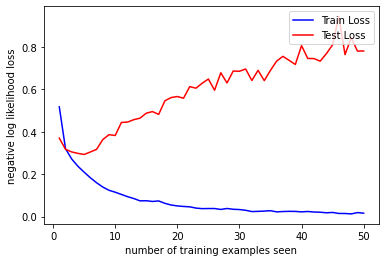

In [ ]:
fig = plt.figure()
plt.plot(range(1,n_epochs+1), train_losses, color='blue')
plt.plot(range(1,n_epochs+1), test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

## visualizing some predections on the test set

In [ ]:
example = enumerate(test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


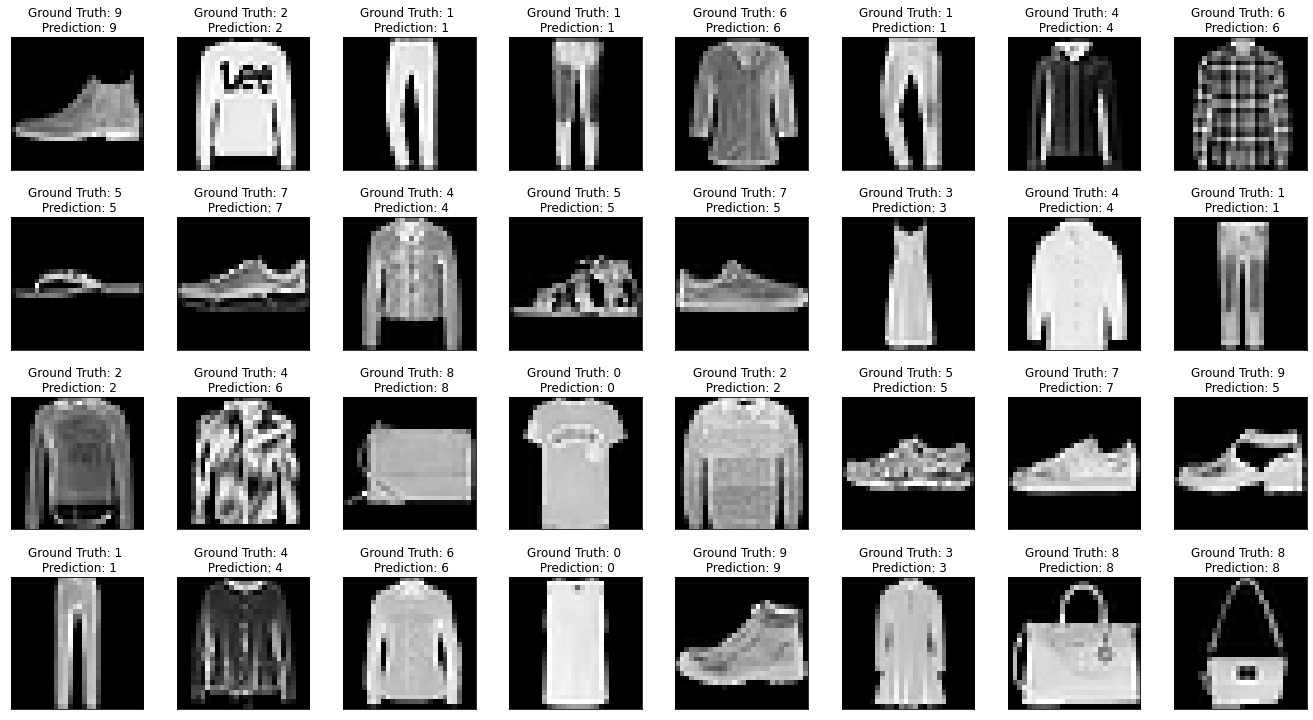

In [ ]:
batc_idx , (example_data,example_target) = next(example)
with torch.no_grad():
  output = network(example_data)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {} \n Prediction: {}".format(example_target[i],output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

#Question 2 Task C.

## creating the network with activation function as a variable to be able to modify it later.

In [13]:
class Net(nn.Module):
    def __init__(self,act_func):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024,1024)
        self.fc2 = nn.Linear(1024,256)
        self.fc3 = nn.Linear(256,10)

        self.act_func = act_func
        self.initializer_wights()

    def forward(self, x):
        x = self.act_func(F.max_pool2d(self.conv1(x), 2))
        x = self.act_func(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 1024)
        x = self.act_func(self.fc1(x))
        x = self.act_func(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)
    
    def initializer_wights(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m,nn.Linear):
          nn.init.xavier_normal_(m.weight)

In [14]:
activation_functions = {F.tanh:"Tanh",F.sigmoid:"Sigmoid",F.elu:"Elu"}
learning_rate = 0.1
results = {}

## perform the training for each activation function and log the test accuracy

In [15]:
for act_func,act_func_name in activation_functions.items():
  network = Net(act_func)
  optimizer = optim.SGD(network.parameters(), lr=learning_rate)

  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []
  print("Training ... ")
  for epoch in range(1, n_epochs + 1):
    print("activation function -> {} \n epoch {}/{} ...".format(act_func_name,epoch,n_epochs))
    train(epoch,network,show_progress=False)
    final_test_accuracy = test(network,show_progress=False)
  results[act_func_name] = final_test_accuracy

Training ... 
activation function -> Tanh 
 epoch 1/50 ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


activation function -> Tanh 
 epoch 2/50 ...
activation function -> Tanh 
 epoch 3/50 ...
activation function -> Tanh 
 epoch 4/50 ...
activation function -> Tanh 
 epoch 5/50 ...
activation function -> Tanh 
 epoch 6/50 ...
activation function -> Tanh 
 epoch 7/50 ...
activation function -> Tanh 
 epoch 8/50 ...
activation function -> Tanh 
 epoch 9/50 ...
activation function -> Tanh 
 epoch 10/50 ...
activation function -> Tanh 
 epoch 11/50 ...
activation function -> Tanh 
 epoch 12/50 ...
activation function -> Tanh 
 epoch 13/50 ...
activation function -> Tanh 
 epoch 14/50 ...
activation function -> Tanh 
 epoch 15/50 ...
activation function -> Tanh 
 epoch 16/50 ...
activation function -> Tanh 
 epoch 17/50 ...
activation function -> Tanh 
 epoch 18/50 ...
activation function -> Tanh 
 epoch 19/50 ...
activation function -> Tanh 
 epoch 20/50 ...
activation function -> Tanh 
 epoch 21/50 ...
activation function -> Tanh 
 epoch 22/50 ...
activation function -> Tanh 
 epoch 23/50 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


activation function -> Sigmoid 
 epoch 2/50 ...
activation function -> Sigmoid 
 epoch 3/50 ...
activation function -> Sigmoid 
 epoch 4/50 ...
activation function -> Sigmoid 
 epoch 5/50 ...
activation function -> Sigmoid 
 epoch 6/50 ...
activation function -> Sigmoid 
 epoch 7/50 ...
activation function -> Sigmoid 
 epoch 8/50 ...
activation function -> Sigmoid 
 epoch 9/50 ...
activation function -> Sigmoid 
 epoch 10/50 ...
activation function -> Sigmoid 
 epoch 11/50 ...
activation function -> Sigmoid 
 epoch 12/50 ...
activation function -> Sigmoid 
 epoch 13/50 ...
activation function -> Sigmoid 
 epoch 14/50 ...
activation function -> Sigmoid 
 epoch 15/50 ...
activation function -> Sigmoid 
 epoch 16/50 ...
activation function -> Sigmoid 
 epoch 17/50 ...
activation function -> Sigmoid 
 epoch 18/50 ...
activation function -> Sigmoid 
 epoch 19/50 ...
activation function -> Sigmoid 
 epoch 20/50 ...
activation function -> Sigmoid 
 epoch 21/50 ...
activation function -> Sigmo

In [16]:
print(results)

{'Tanh': tensor(91.2800), 'Sigmoid': tensor(90.4400), 'Elu': tensor(89.9300)}


## Now we use relu for different learning rates

In [ ]:
learning_rates = [0.001,0.1,0.5,1,10]
results = {}

In [ ]:
for lr in learning_rates:
  network = Net(F.relu)
  optimizer = optim.SGD(network.parameters(), lr=lr)
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []
  print("Training ... ")
  for epoch in range(1, n_epochs + 1):
    print("learning rate = {} \n epoch {}/{} ...".format(lr,epoch,n_epochs))
    train(epoch,network,show_progress=False)
    final_test_accuracy = test(network,show_progress=False)
  results["lr = "+str(lr)] = final_test_accuracy

Training ... 
learning rate = 0.001 
 epoch 1/50 ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


learning rate = 0.001 
 epoch 2/50 ...
learning rate = 0.001 
 epoch 3/50 ...
learning rate = 0.001 
 epoch 4/50 ...
learning rate = 0.001 
 epoch 5/50 ...
learning rate = 0.001 
 epoch 6/50 ...
learning rate = 0.001 
 epoch 7/50 ...
learning rate = 0.001 
 epoch 8/50 ...
learning rate = 0.001 
 epoch 9/50 ...
learning rate = 0.001 
 epoch 10/50 ...
learning rate = 0.001 
 epoch 11/50 ...
learning rate = 0.001 
 epoch 12/50 ...
learning rate = 0.001 
 epoch 13/50 ...
learning rate = 0.001 
 epoch 14/50 ...
learning rate = 0.001 
 epoch 15/50 ...
learning rate = 0.001 
 epoch 16/50 ...
learning rate = 0.001 
 epoch 17/50 ...
learning rate = 0.001 
 epoch 18/50 ...
learning rate = 0.001 
 epoch 19/50 ...
learning rate = 0.001 
 epoch 20/50 ...
learning rate = 0.001 
 epoch 21/50 ...
learning rate = 0.001 
 epoch 22/50 ...
learning rate = 0.001 
 epoch 23/50 ...
learning rate = 0.001 
 epoch 24/50 ...
learning rate = 0.001 
 epoch 25/50 ...
learning rate = 0.001 
 epoch 26/50 ...
learning

In [ ]:
print(results)

{'lr = 0.001': tensor(87.7700), 'lr = 0.1': tensor(90.2500), 'lr = 0.5': tensor(10.), 'lr = 1': tensor(10.), 'lr = 10': tensor(10.)}


#Question 2 Task D.

In [ ]:
class Net(nn.Module):
    def __init__(self,dropout_p):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024,1024)
        self.fc2_dropout = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(1024,256)
        self.fc3 = nn.Linear(256,10)

        self.initializer_wights()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc2_dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x)
    
    def initializer_wights(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m,nn.Linear):
          nn.init.xavier_normal_(m.weight)


In [ ]:
learning_rate = 0.1
dropout_p = 0.3
network = Net(dropout_p)
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
            Conv2d-2             [-1, 64, 8, 8]          51,264
            Linear-3                 [-1, 1024]       1,049,600
            Linear-4                  [-1, 256]         262,400
           Dropout-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
Total params: 1,366,666
Trainable params: 1,366,666
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 5.21
Estimated Total Size (MB): 5.40
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:1630: UserWarning: Dropout is a training op and should not be exported in inference mode. For inference, make sure to call eval() on the model and to export it with param training=False.
  warnings.warn("Dropout is a training op and should not be exported in inference mode. "


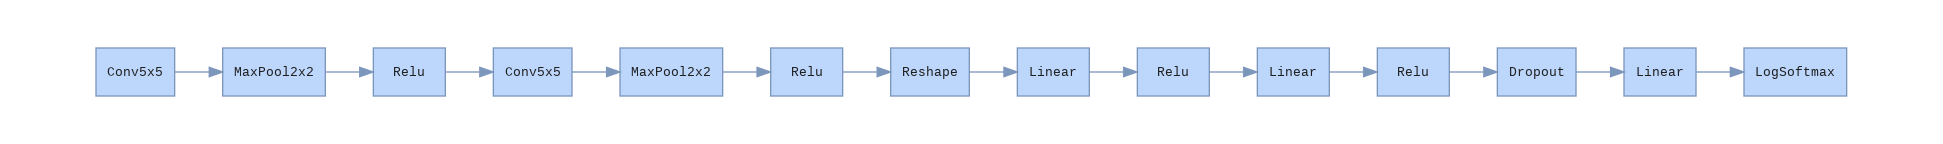

In [ ]:
summary(network,(1,28,28))
transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.

graph = hl.build_graph(network, example_data,transforms = transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('CNN_Model_dropout', format='png')
Image('CNN_Model_dropout.png')

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
print("Training ... ")
for epoch in range(1, n_epochs + 1):
  print("epoch {}/{}----------------------------------------------------------------------".format(epoch,n_epochs))
  train(epoch,network)
  test(network)

Training ... 
epoch 1/50----------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


 	 Training Loss: 0.558303


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3840, Accuracy: 8619/10000 (86%)

epoch 2/50----------------------------------------------------------------------
 	 Training Loss: 0.342080

Test set: Avg. loss: 0.3192, Accuracy: 8830/10000 (88%)

epoch 3/50----------------------------------------------------------------------
 	 Training Loss: 0.292199

Test set: Avg. loss: 0.2918, Accuracy: 8933/10000 (89%)

epoch 4/50----------------------------------------------------------------------
 	 Training Loss: 0.260798

Test set: Avg. loss: 0.2831, Accuracy: 8978/10000 (90%)

epoch 5/50----------------------------------------------------------------------
 	 Training Loss: 0.233317

Test set: Avg. loss: 0.2754, Accuracy: 8994/10000 (90%)

epoch 6/50----------------------------------------------------------------------
 	 Training Loss: 0.210138

Test set: Avg. loss: 0.2879, Accuracy: 8985/10000 (90%)

epoch 7/50----------------------------------------------------------------------
 	 Training Loss: 0.190796

Tes

Text(0, 0.5, 'negative log likelihood loss')

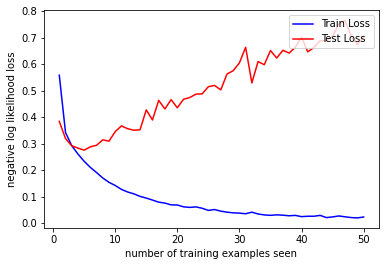

In [ ]:
fig = plt.figure()
plt.plot(range(1,n_epochs+1), train_losses, color='blue')
plt.plot(range(1,n_epochs+1), test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

## testing different dropout rates

In [ ]:
dropout_range = [0.2,0.4,0.6,0.8]
learning_rate = 0.1
result = {}

In [ ]:
for drop_out in range dropout_range:
  
  network = Net(drop_out)
  optimizer = optim.SGD(network.parameters(), lr=lr)
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []
  print("Training ... ")
  for epoch in range(1, n_epochs + 1):
    print("dropout = {} \n epoch {}/{} ...".format(drop_out,epoch,n_epochs))
    final_train_accuracy = train(epoch,network,show_progress=False)
    final_test_accuracy = test(network,show_progress=False)
  results["dropout = "+str(drop_out)] = [final_test_accuracy,final_train_accuracy]